In [12]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
import os
import PIL
import cv2
import glob
import pathlib
import zipfile
import numpy as np
from fastai import *
from PIL import Image
import tensorflow as tf
from fastai.vision import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from matplotlib import pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import *
from tensorflow.keras.models import Sequential
from fastai.metrics import error_rate, accuracy
from keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import Dataset, DataLoader

In [11]:
#Set up paths for train and test data
data_dir = '/content/drive/MyDrive/Team 15 Emotion Recognition/EmotionRecognition/dataset/data/'
train_path = data_dir + 'train/'
test_path = data_dir + 'test/'

'/content/drive/MyDrive/Team 15 Emotion Recognition/EmotionRecognition/dataset/data/train/'

Let's take a look at a few samples from each label to see the types of images we are working with.

## Setting Up Our Data

In [26]:
#use if running locally inside git repo
def mylistdir(directory):
    """A specialized version of os.listdir() that ignores files that
    start with a leading period."""
    #Used to remove .DS_Store from our labels
    filelist = os.listdir(directory)
    return [x for x in filelist
            if not (x.startswith('.'))]

#Display class labels
#labels= mylistdir(train_path)
labels = os.listdir(train_path)
print("Our 7 Emotion Labels:")
labels

Our 7 Emotion Labels:


['happy', 'sad', 'fearful', 'neutral', 'angry', 'disgusted', 'surprised']

In [27]:
file_count = len(list(pathlib.Path(data_dir).glob('*/*/*.png')))
print('Total image count:', file_count)

file_count = len(list(pathlib.Path(train_path).glob('*/*.png')))
print('Total training images:', file_count)

file_count = len(list(pathlib.Path(test_path).glob('*/*.png')))
print('Total testing images:', file_count)

Total image count: 33349
Total training images: 26171
Total testing images: 7178


## Visualizing our data
Let's take a deeper look into our data so we can better understand what we are working with.

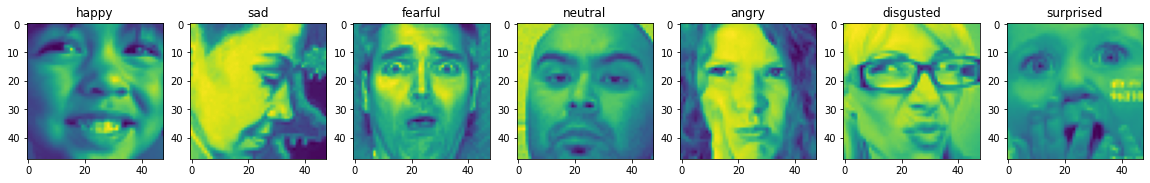

In [28]:
#Display our 7 emotion labels and example image from each class
fig, axes = plt.subplots(1, 7, figsize=(20,20))

for i in range(7):

    ex_image = train_path + labels[i]+ '/' + mylistdir(train_path + labels[i]+'/')[0]
    axes[i].imshow(plt.imread(ex_image))
    axes[i].set_title(labels[i])

plt.show()

Let's also take a look at how our images are distributed accross our 7 emotion labels.

In [15]:
#Print Image Label Distributions
for i in labels:
    print(i, '\nTrain: ' + str(len(os.listdir(train_path + i +'/')))+ ' images' +'\nTest: ' + str(len(os.listdir(test_path+i+'/')))+' images\n')

happy 
Train: 7215 images
Test: 1774 images

sad 
Train: 4830 images
Test: 1247 images

fearful 
Train: 4097 images
Test: 1024 images

neutral 
Train: 4965 images
Test: 1233 images

angry 
Train: 3995 images
Test: 958 images

disgusted 
Train: 436 images
Test: 111 images

surprised 
Train: 633 images
Test: 831 images



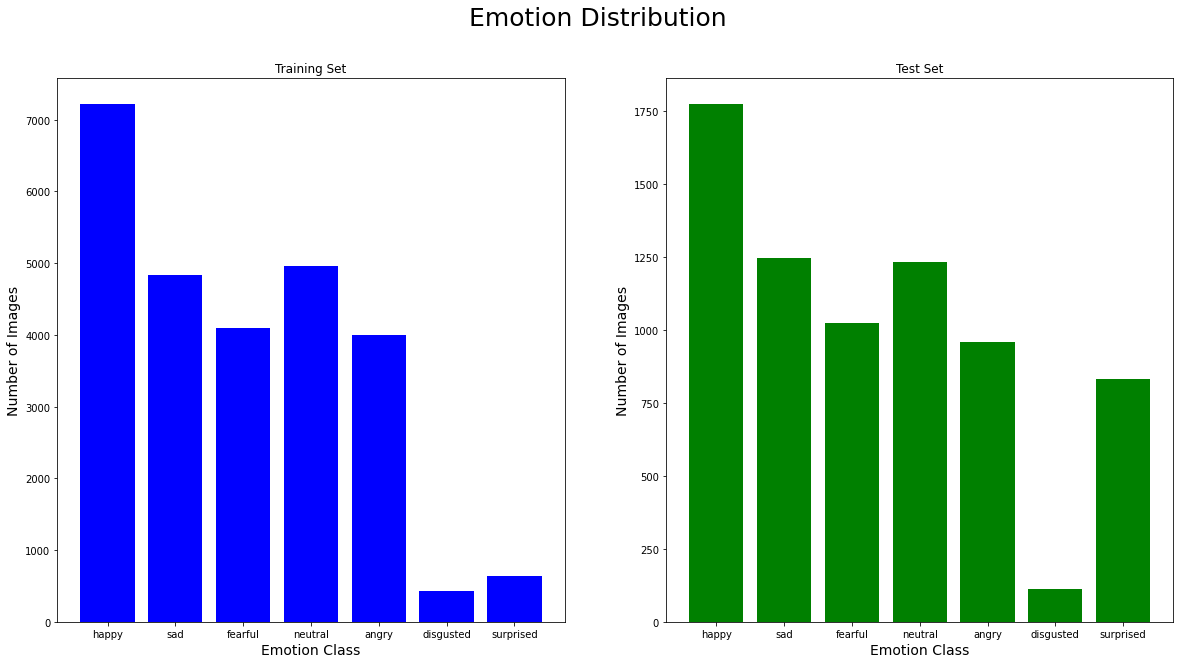

In [29]:
train_dist = np.array([len(os.listdir(train_path+i+'/')) for i in labels])
test_dist = np.array([len(os.listdir(test_path+i+'/')) for i in labels])
x = labels

plt.figure(figsize=(20,10))
plt.suptitle('Emotion Distribution', fontsize=25)

ax1 = plt.subplot(1,2,1)
ax1.set_title('Training Set')
plt.xlabel('Emotion Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.bar(x, train_dist, color='blue')

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('Test Set')
plt.xlabel('Emotion Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.bar(x, test_dist, color='green')
plt.show()

There appears to be an unbalance with a very low amount of images in our Disgusted label. If we do not address these class imbalances, our model may become innacurate and prone to overfitting. Our approach to counteract this is to perform data augmentation & apply weights to our minority and majority classes.

## Data Preprocessing
Now that we have a better understanding of our image data, we can perform data preprocessing on our images to help us expand our dataset and make it more balanced.

Keras ImageDataGenerator allow us to perform image augmentation very easily.

In [17]:
#Define our data augmentations
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range= 0.2,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1.0/255)

#Read our images to the data augmentations
#Generates batches of augmented data
train = train_datagen.flow_from_directory(train_path,
                                          subset='training',
                                          color_mode = 'grayscale',
                                          target_size = (48, 48),
                                          batch_size = 64,
                                          shuffle=True,
                                          class_mode = 'categorical')

valid = train_datagen.flow_from_directory(train_path,
                                          subset='validation',
                                          color_mode = 'grayscale',
                                          target_size = (48, 48),
                                          batch_size = 64,
                                          shuffle=True,
                                          class_mode = 'categorical')

test = test_datagen.flow_from_directory(test_path,
                                        color_mode = 'grayscale',
                                        target_size = (48, 48),
                                        batch_size = 64,
                                        shuffle=False,
                                        class_mode = 'categorical')

Found 20938 images belonging to 7 classes.
Found 5233 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [30]:
train.class_indices

{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

Now that our data is augmented, we can work on building the model.

## Create CNN Model
Motivation for using CNN: 
- We used CNN (Convolutional Neural Network) for our image classification because of its high accuracy, hierarchical model, and ability to automatically detect important features. It is also computationally effective because all of the layers are fully connected.

- Since we wanted to play with using many layers, we can use Keras Sequential model to stack many linear layers together.
- Will be using ReLu as our activation function, and softmax for our final fully connected layer. I decided to use softmax since this is a multi-class classification problem.

In [19]:
'''
Direct Reference: https://www.tensorflow.org/tutorials/images/cnn

Using a common pattern: Stacking Conv2D and MaxPooling2D Layers
'''
#Initialize our model
model = tf.keras.Sequential()

#Input Layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #max pooling to decrease dimension
model.add(Dropout(0.25)) #test

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #max pooling to decrease dimension
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.25))

'''model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) #max pooling to decrease dimension
model.add(Dropout(0.2))'''

model.add(Flatten()) #Flattens our data into a vector

model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation = 'softmax')) #Final dense layer always equal to the number of classes (7)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

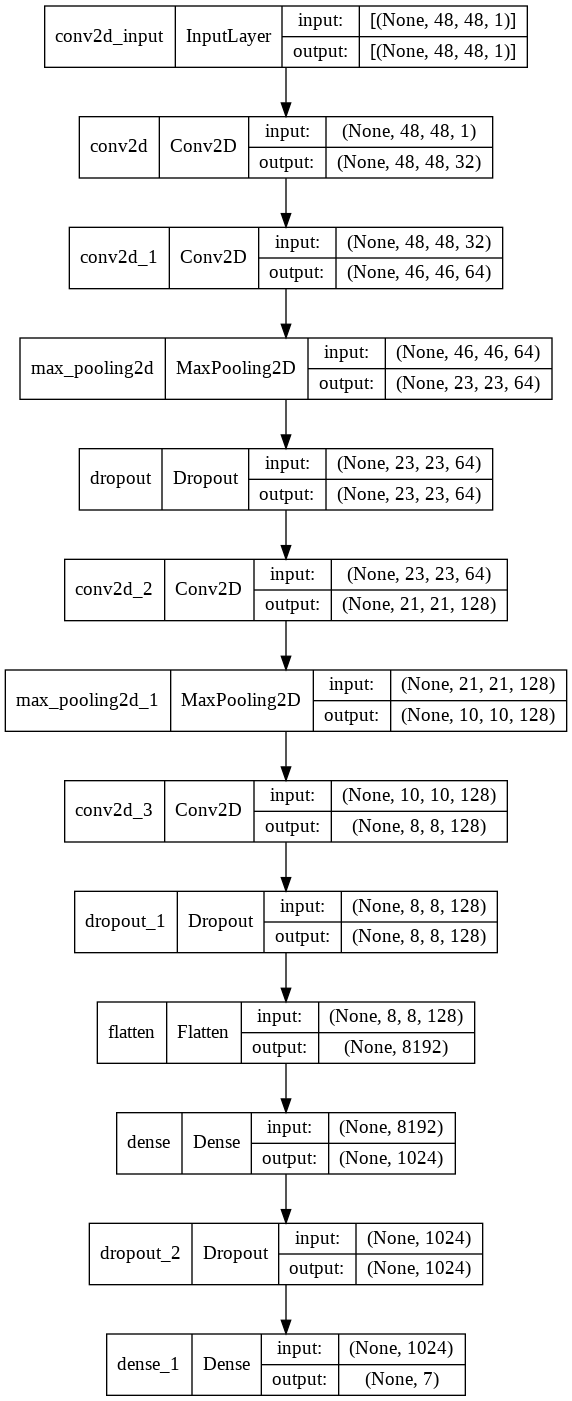

In [24]:
tf.keras.utils.plot_model(model, to_file='emotion-model.png', show_shapes=True, show_layer_names=True)

In [ ]:
'''from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

vgg = VGG19(weights='imagenet', include_top=False, classes=7)

#freeze
for layer in vgg.layers:
    layer.trainable = False
    
input = Input(shape=(48,48,1)) #Our input image size

conv = Conv2D(3, kernel_size=(3,3), padding='same')(input)
vgg = vgg(conv)
x = Flatten()(vgg)
pred = Dense(7, activation='softmax')(x)

model = Model(inputs=input, outputs=pred)'''

## Compiling and Fitting the Model
We will implement a callback function that when called during training, will allow the model to stop once the best loss is found, or reduce the learning rate for better performance

In [43]:
'''{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}'''
train.batch_size

64

In [44]:
'''
Direct Reference: https://keras.io/api/callbacks/
'''
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(train.classes), 
                                                  y=train.classes)
class_weights = dict(zip(np.unique(train.classes),class_weights))

filepath = '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5' #saves our best model to this location with custom name
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_delta=0.0001, verbose=1),
             tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss',verbose=1, save_best_only=True, mode='min'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1,restore_best_weights=True)]


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
emotion = model.fit(train, validation_data=valid, epochs=50, class_weight=class_weights)

Epoch 1/50
  2/328 [..............................] - ETA: 2:29:37 - loss: 1.7698 - accuracy: 0.0781

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='../input/emotion/model_plot.png', show_shapes=True, show_layer_names=True

In [ ]:
loss,acc = model.evaluate(test,verbose=2)

In [ ]:
#Saving our model/weights
model.save('../input/emotion/emotion-detection.h5')
model.save_weights('../input/emotion/emotion_weight.h5')
np.save("history", emotion.history)
print('saved model to disk.')

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle('Loss & Accuracy Over Time', fontsize=25)

plt.subplot(1, 2, 1)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(model_train.history['loss'], label='Training Loss')
plt.plot(model_train.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(model_train.history['accuracy'], label='Training Accuracy')
plt.plot(model_train.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.show()

## Looking Deeper
Let's see a visual prediction of an image in our test dataset.

In [ ]:
img = image.load_img(test_path+"/surprised/im30.png",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)

Lets print out the prediction from the model as well as our class labels. The softmax function outputs a list with varying numbers, the index of the highest number is what the model predicts to be the emotion of the given image.

In [ ]:
img = np.expand_dims(img,axis = 0) #reshapes to 1,48,48
img = img.reshape(1,48,48,1)
result = model.predict(img) #using model to predict emotion of image
result = list(result[0])

#print result - we see that the image slightly detected the fearful emotion as well as surprised
print(result)
print(labels)

In [ ]:
img_index = result.index(max(result))
print('Prediction:',labels[img_index])

In [ ]:
img = image.load_img('../input/emotion/allyson.jpg', target_size=(48,48),color_mode='grayscale')
img = np.array(img)
plt.imshow(img)

In [ ]:
img = np.expand_dims(img,axis = 0) #reshapes to 1,48,48
img = img.reshape(1,48,48,1)
result = model.predict(img) #using model to predict emotion of image
result = list(result[0])

#print result - we see that the image slightly detected the fearful emotion as well as surprised
print(result)